<a href="https://colab.research.google.com/github/wizard339/education/blob/main/reinforcement_dqn_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 37.9 MB/s eta 0:00:00


In [2]:
import time
import random
import numpy as np

import gym
import pygame

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.9.2


In [ ]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1ca49f28-8277-c648-ffde-d37284d2baf6)


## Load GYM environment

In [3]:
env = gym.make('CartPole-v0')

STATE_LIMITS = env.observation_space
NUM_ACTIONS = env.action_space.n

print('Actions: {}'.format(NUM_ACTIONS))
print('States limits:')
for i in range(STATE_LIMITS.shape[0]):
    print('[{}, {}]'.format(STATE_LIMITS.low[i], STATE_LIMITS.high[i]))

Actions: 2
States limits:
[-4.800000190734863, 4.800000190734863]
[-3.4028234663852886e+38, 3.4028234663852886e+38]
[-0.41887903213500977, 0.41887903213500977]
[-3.4028234663852886e+38, 3.4028234663852886e+38]


/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Settings

In [4]:
LR = 0.001
gamma = 0.95

NUM_EPISODES = 2000
MAX_STEPS = 200
REWARD_AVERAGE_WINDOW = 20

## DQN Model

In [5]:
model = M.Sequential([
    L.Dense(24, activation='relu'),
    L.Dense(24, activation='relu'),
    L.Dense(NUM_ACTIONS, activation=None, use_bias=False),
])

def evalQ(s):
    return model(s[None, ...].astype(np.float32)).numpy()[0]

## Prepare model for training

In [6]:
#def loss(q1, q2):
#    return tf.reduce_sum(tf.square(q1 - q2))

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(loss='mse', optimizer=optimizer)

pathLenList = []
totalRewardList = []
totalRewardAverageList = []

## DQN training

In [14]:
for i in range(NUM_EPISODES):
    
    eps = 1./((i/50) + 10)
    
    s = env.reset()
    
    totalReward = 0
    step = 0
    
    while step < MAX_STEPS:
        step += 1

        Q_s = evalQ(s)
        
        if np.random.rand() < eps:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q_s)

        s1, r, done, _ = env.step(a)

        Q_s1 = evalQ(s1)
        
        Q_target = Q_s
        if done:
            Q_target[a] = r
        else:
            Q_target[a] = r + gamma * np.max(Q_s1)
 
        model.train_on_batch(s[None, ...].astype(np.float32), Q_target[None, ...])

        totalReward += r
        s = s1
        
        if done:
            break
            
    pathLenList.append(step)
    totalRewardList.append(totalReward)

    if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
        totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
        totalRewardAverageList.append(totalRewardAverage)
        if i % 100 == 0:
            print('Episode {}: average total reward = {}'.format(i, totalRewardAverage))

Episode 100: average total reward = 11.0
Episode 200: average total reward = 19.45
Episode 300: average total reward = 18.25
Episode 400: average total reward = 39.1
Episode 500: average total reward = 46.9
Episode 600: average total reward = 32.9
Episode 700: average total reward = 63.55
Episode 800: average total reward = 83.65
Episode 900: average total reward = 98.75
Episode 1000: average total reward = 134.2
Episode 1100: average total reward = 29.85
Episode 1200: average total reward = 14.5
Episode 1300: average total reward = 179.4
Episode 1400: average total reward = 98.3
Episode 1500: average total reward = 130.55
Episode 1600: average total reward = 138.7
Episode 1700: average total reward = 137.75
Episode 1800: average total reward = 106.1
Episode 1900: average total reward = 166.3


## Plot trajectory length over time

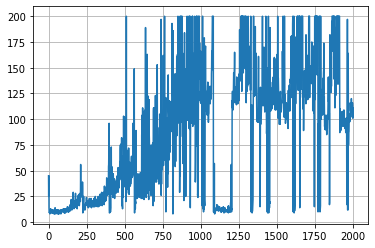

In [15]:
plt.plot(pathLenList)
plt.grid()

## Plot average total reward over time

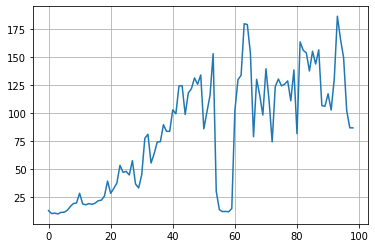

In [16]:
plt.plot(totalRewardAverageList)
plt.grid()

In [7]:
RECORD_VIDEO = True

if RECORD_VIDEO:
  
    !pip install pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

## Run simulation

In [17]:
USE_Q = True

if RECORD_VIDEO:
    from gym.wrappers.record_video import RecordVideo
    env_sim = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
else:
    env_sim = env
    
s = env_sim.reset()
totalReward = 0

for _ in range(1000):
    env_sim.render()
    if USE_Q:
        a = np.argmax(evalQ(s))
    else:
        a = env_sim.action_space.sample()    
    s, r, done, _ = env_sim.step(a)
    totalReward += r
    if done:
        break
       
    if not RECORD_VIDEO:
        time.sleep(1./30)
        
env_sim.close()

print('Total reward = {}'.format(totalReward))

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initiali

Total reward = 191.0


## Show the video

In [18]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
show_video()